# CSCE 5222 Feature Engineering — Gabor Filter Bank on SOCOFing (Real vs Altered)

Group 7  
Members: Amir Naderian, Alireza Mohammadshafie

---

## 1. Problem Statement
For this project, we explore how a Gabor filter bank can be used to extract meaningful features from images. Gabor filters capture texture and edges by responding to specific orientations and spatial frequencies. Our goal is to evaluate how well these features distinguish between fingerprint images that are Real versus Altered.

## 2. Data Used
We use the SOCOFing fingerprint dataset located at `SOCOFing/` with two top-level classes:
- `Real/`
- `Altered/` (contains subfolders for difficulty levels)

Each image is associated with a ground truth label indicating its class. Before applying the filters, we resize images to a consistent size and convert them to grayscale for comparable filter responses.

## 3. Method
- Filter Bank Design: Gabor kernels at orientations 0°, 45°, 90°, 135°, 180° and multiple frequencies.
- Feature Extraction: Convolve each image with the filter bank and collect summary statistics (mean and standard deviation) from the magnitude responses.
- Classification: Train and compare two classifiers (SVM with RBF kernel and k-NN) on the extracted features.



In [15]:
# Setup & Config

import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io, color, transform
from skimage.filters import gabor

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

import joblib
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Paths
PROJECT_ROOT = Path("/Users/alireza.mohammadshafie/Documents/Projects/Feature_engineering/Project")
DEFAULT_DATASET = PROJECT_ROOT / "SOCOFing"
DATASET_ROOT = DEFAULT_DATASET if DEFAULT_DATASET.exists() else Path("SOCOFing").resolve()
print(f"Dataset root: {DATASET_ROOT}")

# Parameters
IMG_SIZE = (128, 128)
THETAS_DEG = [0, 45, 90, 135, 180]
FREQS = [0.1, 0.2, 0.3]
POS_LABEL = 1  # Altered

# Optional subsampling per class for quick runs; set to an int or None
MAX_PER_CLASS = None  # e.g., 100

# Splits and CV
TEST_SIZE = 0.20
VAL_SIZE = 0.20  # of the whole dataset
CV_FOLDS = 5
N_JOBS = -1

# Plotting style
sns.set_theme(style="whitegrid", context="notebook")


Dataset root: /Users/alireza.mohammadshafie/Documents/Projects/Feature_engineering/Project/SOCOFing


In [16]:
# Dataset loading & labeling

from typing import List

SUPPORTED_EXTS = {".bmp", ".png", ".jpg", ".jpeg", ".tif", ".tiff"}

real_dir = DATASET_ROOT / "Real"
altered_dir = DATASET_ROOT / "Altered"


real_files = find_images(real_dir)
altered_files = find_images(altered_dir)

# Deterministic order then optional subsampling
real_files = sorted(real_files)
altered_files = sorted(altered_files)

if MAX_PER_CLASS is not None:
    real_files = real_files[:MAX_PER_CLASS]
    altered_files = altered_files[:MAX_PER_CLASS]

if len(real_files) == 0 or len(altered_files) == 0:
    raise RuntimeError("No images found in one or more classes. Check dataset path and structure.")

rows = []
for p in real_files:
    rows.append({"path": p, "label": 0, "label_str": "Real"})
for p in altered_files:
    rows.append({"path": p, "label": 1, "label_str": "Altered"})

_df = pd.DataFrame(rows)
_df = _df.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)  # shuffle

df = _df
print(f"Found {len(real_files)} Real and {len(altered_files)} Altered images.")
print(df.groupby("label_str").size())

df.head()


Found 6000 Real and 49270 Altered images.
label_str
Altered    49270
Real        6000
dtype: int64


,path,label,label_str
0,/Users/alireza.mohammadshafie/Documents/Projec...,1,Altered
1,/Users/alireza.mohammadshafie/Documents/Projec...,1,Altered
2,/Users/alireza.mohammadshafie/Documents/Projec...,1,Altered
3,/Users/alireza.mohammadshafie/Documents/Projec...,1,Altered
4,/Users/alireza.mohammadshafie/Documents/Projec...,1,Altered


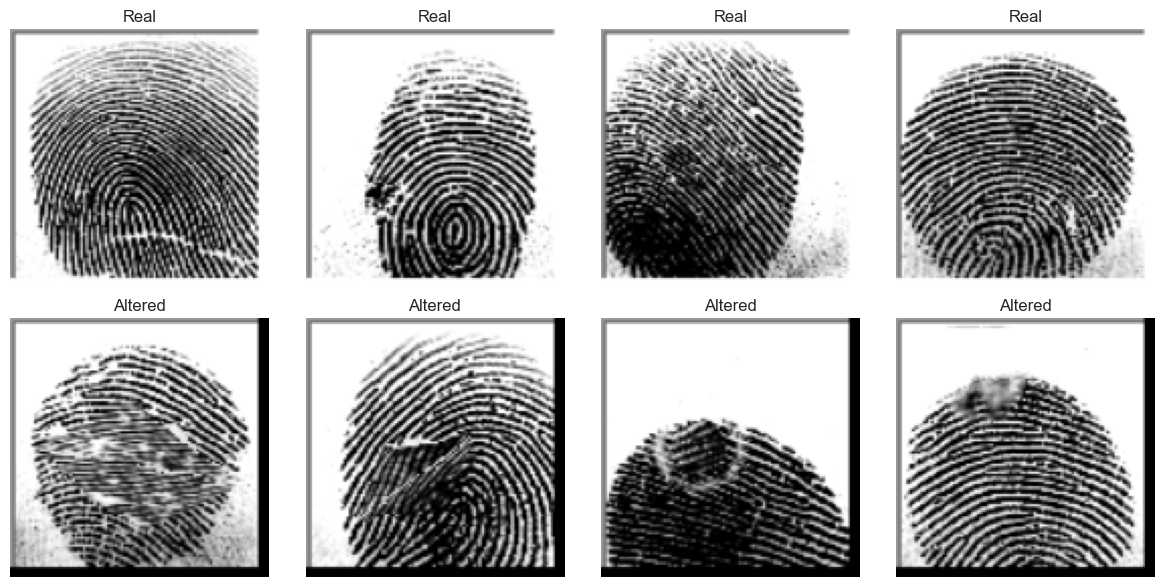

In [17]:
# Quick EDA: visualize samples and verify preprocessing

from math import ceil


def load_gray_and_resized(path: Path, size=(128, 128)):
    img = io.imread(path.as_posix())
    if img.ndim == 3:
        # Handle RGBA -> RGB, single-channel stacks, and standard RGB
        if img.shape[2] == 4:  # RGBA
            img = color.rgba2rgb(img)
            img_gray = color.rgb2gray(img)
        elif img.shape[2] == 3:  # RGB
            img_gray = color.rgb2gray(img)
        elif img.shape[2] == 1:  # Single-channel in last axis
            img_gray = img[..., 0]
        else:  # Fallback: take first 3 channels as RGB
            img_gray = color.rgb2gray(img[..., :3])
    else:
        img_gray = img.astype(np.float32)
    img_resized = transform.resize(
        img_gray, size, anti_aliasing=True, mode="reflect", preserve_range=True
    )
    return img_gray, img_resized


def show_samples(df_samples: pd.DataFrame, n_per_class: int = 4, size=(128, 128)):
    classes = ["Real", "Altered"]
    n_cols = n_per_class
    n_rows = len(classes)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    if n_rows == 1:
        axes = np.expand_dims(axes, 0)
    for r, cls in enumerate(classes):
        subset = df_samples[df_samples["label_str"] == cls]
        subset = subset.sample(n=min(n_per_class, len(subset)), random_state=RANDOM_STATE)
        for c, (_, row) in enumerate(subset.reset_index(drop=True).iterrows()):
            _, img_resized = load_gray_and_resized(row["path"], size=size)
            ax = axes[r, c]
            ax.imshow(img_resized, cmap="gray")
            ax.set_title(f"{cls}")
            ax.axis("off")
    plt.tight_layout()
    plt.show()


show_samples(df, n_per_class=4, size=IMG_SIZE)


In [18]:
# Gabor utilities

import numpy as np
from skimage.filters import gabor


def compute_gabor_features(image_gray: np.ndarray, thetas_deg, freqs) -> np.ndarray:
    """Compute Gabor magnitude mean/std features over all theta-frequency pairs."""
    features = []
    for theta_deg in thetas_deg:
        theta = np.deg2rad(theta_deg)
        for freq in freqs:
            real, imag = gabor(image_gray, frequency=freq, theta=theta)
            mag = np.sqrt(real * real + imag * imag)
            features.extend([float(mag.mean()), float(mag.std())])
    return np.asarray(features, dtype=np.float32)


def image_to_feature_vector(path: Path) -> np.ndarray:
    """Read image, convert to grayscale, resize, then compute Gabor features."""
    _, img_resized = load_gray_and_resized(path, size=IMG_SIZE)
    # Ensure range [0,1] float
    if img_resized.dtype != np.float32 and img_resized.dtype != np.float64:
        img_resized = img_resized.astype(np.float32)
    img_resized = np.clip(img_resized, 0, 1)
    return compute_gabor_features(img_resized, THETAS_DEG, FREQS)


In [19]:
# Feature extraction

num_features = 2 * len(THETAS_DEG) * len(FREQS)
print(f"Each image will produce {num_features} features.")

X = np.empty((len(df), num_features), dtype=np.float32)
y = df["label"].to_numpy(dtype=np.int64)

for i, row in enumerate(df.itertuples(index=False)):
    X[i, :] = image_to_feature_vector(row.path)
    if (i + 1) % 200 == 0:
        print(f"Processed {i+1}/{len(df)} images...")

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Each image will produce 30 features.
Processed 200/55270 images...


KeyboardInterrupt: 

In [ ]:
# Split & scale

# First split: test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Second split: validation from the remaining pool
val_size_adjusted = VAL_SIZE / (1.0 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_size_adjusted,
    stratify=y_train_val,
    random_state=RANDOM_STATE,
)

print("Splits:")
print({
    "train": X_train.shape,
    "val": X_val.shape,
    "test": X_test.shape,
})

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

print("Scaled feature shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)


Splits:
{'train': (33162, 30), 'val': (11054, 30), 'test': (11054, 30)}
Scaled feature shapes: (33162, 30) (11054, 30) (11054, 30)


In [ ]:
# Train SVM (RBF) with grid search

svm = SVC(kernel="rbf", class_weight="balanced", probability=False, random_state=RANDOM_STATE)
param_grid_svm = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 0.01, 0.001],
}
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    scoring="accuracy",
    cv=cv,
    n_jobs=N_JOBS,
    verbose=1,
    refit=True,
)

grid_svm.fit(X_train_s, y_train)

print("SVM best params:", grid_svm.best_params_)
print("SVM best CV accuracy:", grid_svm.best_score_)

best_svm = grid_svm.best_estimator_

# Optional: validation performance
svm_val_acc = accuracy_score(y_val, best_svm.predict(X_val_s))
svm_val_prec = precision_score(y_val, best_svm.predict(X_val_s), pos_label=POS_LABEL, zero_division=0)
print({"svm_val_acc": svm_val_acc, "svm_val_prec": svm_val_prec})


Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM best params: {'C': 10, 'gamma': 'scale'}
SVM best CV accuracy: 0.9999698477310417
{'svm_val_acc': 0.9998190700199023, 'svm_val_prec': 0.9998985183681753}


In [ ]:
# Train k-NN with grid search

knn = KNeighborsClassifier()
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],
    "metric": ["euclidean", "manhattan"],
}
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring="accuracy",
    cv=cv,
    n_jobs=N_JOBS,
    verbose=1,
    refit=True,
)

grid_knn.fit(X_train_s, y_train)

print("k-NN best params:", grid_knn.best_params_)
print("k-NN best CV accuracy:", grid_knn.best_score_)

best_knn = grid_knn.best_estimator_

# Optional: validation performance
knn_val_acc = accuracy_score(y_val, best_knn.predict(X_val_s))
knn_val_prec = precision_score(y_val, best_knn.predict(X_val_s), pos_label=POS_LABEL, zero_division=0)
print({"knn_val_acc": knn_val_acc, "knn_val_prec": knn_val_prec})


Fitting 5 folds for each of 8 candidates, totalling 40 fits
k-NN best params: {'metric': 'euclidean', 'n_neighbors': 3}
k-NN best CV accuracy: 0.9995778364092104
{'knn_val_acc': 0.9998190700199023, 'knn_val_prec': 0.999797077922078}


In [ ]:
# Evaluation on test set

# Predict
svm_test_pred = best_svm.predict(X_test_s)
knn_test_pred = best_knn.predict(X_test_s)

# Metrics
svm_test_acc = accuracy_score(y_test, svm_test_pred)
svm_test_prec = precision_score(y_test, svm_test_pred, pos_label=POS_LABEL, zero_division=0)

knn_test_acc = accuracy_score(y_test, knn_test_pred)
knn_test_prec = precision_score(y_test, knn_test_pred, pos_label=POS_LABEL, zero_division=0)

results_df = pd.DataFrame([
    {"Model": "SVM (RBF)", "Accuracy": svm_test_acc, "Precision": svm_test_prec},
    {"Model": "k-NN", "Accuracy": knn_test_acc, "Precision": knn_test_prec},
])

print("Results (test set):")
results_df



Results (test set):


,Model,Accuracy,Precision
0,SVM (RBF),0.999910,0.999899
1,k-NN,0.999638,0.999594


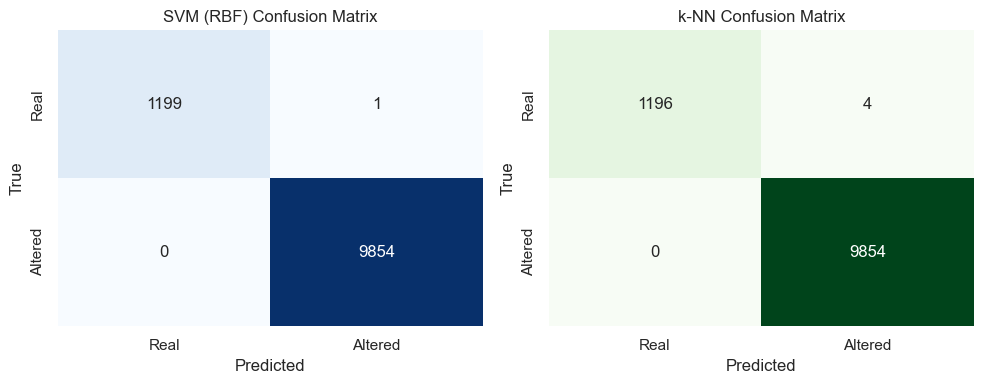


SVM (RBF) Classification Report:

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      1200
     Altered       1.00      1.00      1.00      9854

    accuracy                           1.00     11054
   macro avg       1.00      1.00      1.00     11054
weighted avg       1.00      1.00      1.00     11054

k-NN Classification Report:

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      1200
     Altered       1.00      1.00      1.00      9854

    accuracy                           1.00     11054
   macro avg       1.00      1.00      1.00     11054
weighted avg       1.00      1.00      1.00     11054



In [ ]:
# Confusion matrices and classification reports

labels = [0, 1]
label_names = {0: "Real", 1: "Altered"}

cm_svm = confusion_matrix(y_test, svm_test_pred, labels=labels)
cm_knn = confusion_matrix(y_test, knn_test_pred, labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_svm, annot=True, fmt="d", cbar=False, ax=axes[0], cmap="Blues")
axes[0].set_title("SVM (RBF) Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_xticklabels([label_names[l] for l in labels])
axes[0].set_yticklabels([label_names[l] for l in labels])

sns.heatmap(cm_knn, annot=True, fmt="d", cbar=False, ax=axes[1], cmap="Greens")
axes[1].set_title("k-NN Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_xticklabels([label_names[l] for l in labels])
axes[1].set_yticklabels([label_names[l] for l in labels])

plt.tight_layout()
plt.show()

print("\nSVM (RBF) Classification Report:\n")
print(classification_report(y_test, svm_test_pred, target_names=["Real", "Altered"], zero_division=0))

print("k-NN Classification Report:\n")
print(classification_report(y_test, knn_test_pred, target_names=["Real", "Altered"], zero_division=0))
